In [67]:
# from google.colab import drive
# drive.mount('/content/drive')

In [68]:
!nvidia-smi

Tue Aug  1 13:02:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
# !rm -r indonlu

In [70]:
!git clone https://github.com/ezaaputra/indonlu.git

fatal: destination path 'indonlu' already exists and is not an empty directory.


# 1. Import Library

In [71]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

In [72]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Exploratory Data Analysis

In [73]:
df_path = 'vision_mentah_baru.csv'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_gokil.csv'

In [74]:
# Import data
df = pd.read_csv(df_path)

In [75]:
df.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
2877,905fae9a-e9ff-4ee5-9d44-621cef191d05,dara azizah,https://play-lh.googleusercontent.com/a/AGNmyx...,Ini aplikasi nya kenapa yaa kemaren saya nonto...,1,0,4.4.60,2020-11-01 17:40:49,Mohon Maaf atas ketidaknyamanannya. Untuk kend...,2020-11-01 18:39:00
597,e47449ec-b06b-4055-a0a9-ec91cc971490,LEENA APRILLIA,https://play-lh.googleusercontent.com/a/AGNmyx...,Sekarang kok jelek sih udah langganan masak mo...,3,0,NaN,2023-04-17 19:26:58,Hi Villenial...Mohon Maaf atas ketidaknyamanan...,2023-04-17 21:51:27
3667,e9025770-0e07-47f2-8b4b-2b115ebe844d,Tiharoh sanusi,https://play-lh.googleusercontent.com/a/AGNmyx...,mantap banyak saluran barunya nih jadi lebih b...,5,0,NaN,2020-10-15 12:40:19,"Terima kasih atas review-nya, selamat menikmat...",2020-10-15 12:53:23
3230,d26e2893-31b7-458d-8eee-f4072f100bba,Syafiq VR,https://play-lh.googleusercontent.com/a/AGNmyx...,Blm ngebuka aplikasi tiba2 keluar dengan sendi...,1,0,6.22.0,2022-12-23 16:23:11,NaN,NaN
215,68e67ea6-a487-4f6d-b185-b3417a25b0d9,Fikri Imanulhaq,https://play-lh.googleusercontent.com/a-/ACB-R...,Bagus Aplikasinya.. Tolong diperbaiki lagi ten...,5,1,6.22.0,2022-12-21 19:04:41,Hi kak Fikri Imanulhaq ....Terima kasih atas r...,2022-12-21 19:16:49


In [76]:
# Function to remove characters and dots from a string
def remove_chars_and_dots(text):
    return text.replace(".", "").replace("-", "").replace("_", "").replace("?", "").replace("!", "").replace("*", "").replace("#", "").replace("@", "").replace("&", "").replace("$", "").replace("(", "").replace(")", "").replace("{", "").replace("}", "").replace("[", "").replace("]", "").replace("<", "").replace(">", "").replace("|", "").replace("\\", "").replace("/", "").replace(",", "").replace(";", "").replace(":", "")

# Apply the remove_chars_and_dots function to the 'content' column
df['content'] = df['content'].apply(remove_chars_and_dots)

df.sample(5)



,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
6337,341bce43-1181-48c5-845b-1efd55249587,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,channel luar filmnya selalu di ulang2 semakin ...,3,0,3.3.15,2018-12-26 3:23:04,"Terima kasih reviewnya, kami akan terus tingka...",2018-12-26 8:36:56
7255,0578c6c8-759f-4940-b80e-bacfd680b6cc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Udah lama download ini cuma buat nonton preman...,1,0,NaN,2019-11-21 9:06:01,Mohon Maaf atas ketidaknyamanannya. Untuk Seri...,2019-11-21 9:29:56
4822,427b2609-92d7-4f55-b233-5d336a2d9bd0,Yusuf Mhmmd,https://play-lh.googleusercontent.com/a-/ACB-R...,sangat oke buat nntn tv bisa dimana aja kualit...,5,0,NaN,2020-11-24 19:45:44,"Terima kasih atas review-nya, selamat menikmat...",2020-11-25 9:54:06
3852,01bfab5e-0f3d-4861-936d-07caa466e094,Aziih Rachman,https://play-lh.googleusercontent.com/a/AGNmyx...,sangat tidak menyenangkan kenapa sekarang visi...,1,0,6.18.0,2022-09-07 6:25:33,Hi kak Aziih...Mohon Maaf atas ketidaknyamanan...,2022-09-07 8:07:20
3537,5188e769-e3ad-480a-803e-67b0d610830e,hand dorie,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasi sampah sekali FC terus parah,1,0,6.22.0,2023-01-12 19:04:24,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2023-01-12 20:13:25


In [77]:
print(f'shape: {df.shape}')

shape: (8000, 10)


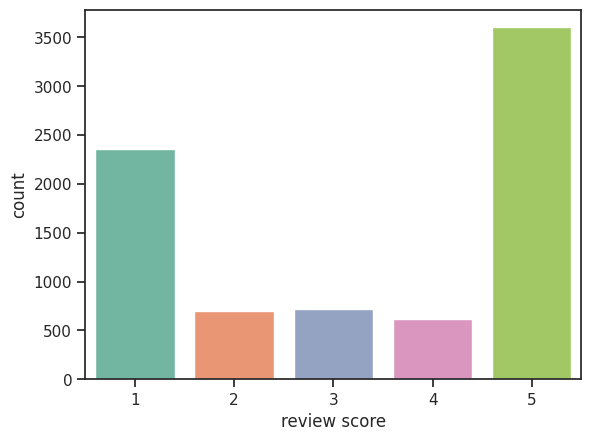

In [78]:
sns.countplot(x=df["score"])
plt.xlabel('review score');

In [79]:
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset
df['category'] = df["score"].apply(to_sentiment)


In [80]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
0,e62be63f-800b-4aa1-acb1-235a13cd3ba9,Muhammad Sofyan Zain,https://play-lh.googleusercontent.com/a-/ACB-R...,Saya masih ngetes dulu nih berlangganan 1 bula...,1,4,6.24.0,2023-04-28 19:36:30,Hi Villenial...Mohon Maaf atas ketidaknyamanan...,2023-04-28 21:13:27,0
1,8857ee5e-6a31-404e-a3bc-547b0c2337ba,Dinna Agsari,https://play-lh.googleusercontent.com/a-/ACB-R...,Tolong tingkatkan lagi Lagi enak2 nonton sampa...,1,29,6.24.0,2023-04-23 9:10:39,Mohon Maaf atas ketidaknyamanannya kak Dinna. ...,2023-04-23 10:15:16,0
2,c7de4e7e-dd9a-4319-9186-4ee6abb3bec6,Bary Hastomo Kristyadi,https://play-lh.googleusercontent.com/a-/ACB-R...,Wah Status langganan masih aktif tp dipake nnt...,1,1,6.24.0,2023-04-29 20:23:21,Mohon Maaf atas ketidaknyamanannya kak Bary .....,2023-04-30 0:50:53,0
3,4d2a5e1d-a99c-4b18-a2d0-75252bf6d544,Syamila,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasinya jelek udah langganan premium eh bu...,1,1,6.24.0,2023-04-28 14:06:58,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-28 14:17:52,0
4,2e1c3d16-21e5-4d33-a626-08ba1d003c75,Ash,https://play-lh.googleusercontent.com/a-/ACB-R...,Kalo mau pilih episode susah dipencet2 tetep g...,2,52,6.22.0,2023-02-07 20:19:35,Hi Villenial....Mohon maaf atas ketidaknyamana...,2023-02-07 20:35:53,0


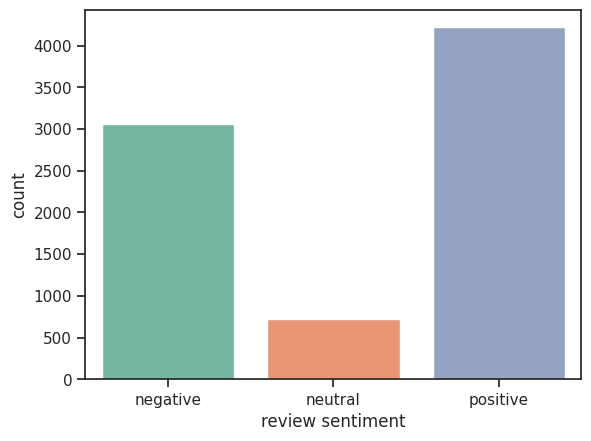

In [81]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x = df["category"])
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)

plt.xlabel('review sentiment')
plt.show()

In [82]:
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

# Apply to the dataset
df['category'] = df["score"].apply(to_sentiment)

In [83]:
df["category"].value_counts()

positive    4219
negative    3060
neutral      721
Name: category, dtype: int64

## Proporsi Variabel Target

In [84]:
df['category'].value_counts()

positive    4219
negative    3060
neutral      721
Name: category, dtype: int64

In [85]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

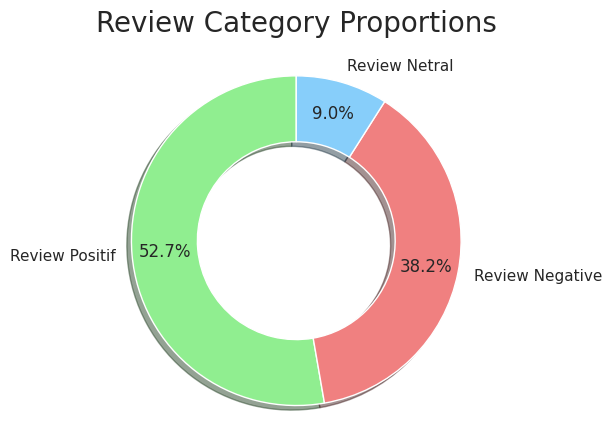

In [86]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))
# Plot arguments
sizes = df.category.value_counts()
labels = ['Review Positif', 'Review Negative', 'Review Netral']
colors = ['lightgreen', 'lightcoral', 'lightskyblue']
explode = (0,0,0)
# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [87]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [88]:
df['content'] = df['content'].str.replace('!', '')

df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
0,e62be63f-800b-4aa1-acb1-235a13cd3ba9,Muhammad Sofyan Zain,https://play-lh.googleusercontent.com/a-/ACB-R...,Saya masih ngetes dulu nih berlangganan 1 bula...,1,4,6.24.0,2023-04-28 19:36:30,Hi Villenial...Mohon Maaf atas ketidaknyamanan...,2023-04-28 21:13:27,negative
1,8857ee5e-6a31-404e-a3bc-547b0c2337ba,Dinna Agsari,https://play-lh.googleusercontent.com/a-/ACB-R...,Tolong tingkatkan lagi Lagi enak2 nonton sampa...,1,29,6.24.0,2023-04-23 9:10:39,Mohon Maaf atas ketidaknyamanannya kak Dinna. ...,2023-04-23 10:15:16,negative
2,c7de4e7e-dd9a-4319-9186-4ee6abb3bec6,Bary Hastomo Kristyadi,https://play-lh.googleusercontent.com/a-/ACB-R...,Wah Status langganan masih aktif tp dipake nnt...,1,1,6.24.0,2023-04-29 20:23:21,Mohon Maaf atas ketidaknyamanannya kak Bary .....,2023-04-30 0:50:53,negative
3,4d2a5e1d-a99c-4b18-a2d0-75252bf6d544,Syamila,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasinya jelek udah langganan premium eh bu...,1,1,6.24.0,2023-04-28 14:06:58,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-28 14:17:52,negative
4,2e1c3d16-21e5-4d33-a626-08ba1d003c75,Ash,https://play-lh.googleusercontent.com/a-/ACB-R...,Kalo mau pilih episode susah dipencet2 tetep g...,2,52,6.22.0,2023-02-07 20:19:35,Hi Villenial....Mohon maaf atas ketidaknyamana...,2023-02-07 20:35:53,negative


In [89]:
import string
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# ------ Tokenizing ---------

def remove_review_text_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

df['content'] = df['content'].apply(remove_review_text_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['content'] = df['content'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  return text

df['content'] = df['content'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['content'] = df['content'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['content'] = df['content'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['content'] = df['content'].apply(remove_singl_char)

# NLTK word rokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

In [90]:
df_v1 = df

In [91]:
# export to tsv
df_v1.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [92]:
df_v1.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
0,e62be63f-800b-4aa1-acb1-235a13cd3ba9,Muhammad Sofyan Zain,https://play-lh.googleusercontent.com/a-/ACB-R...,Saya masih ngetes dulu nih berlangganan bulan ...,1,4,6.24.0,2023-04-28 19:36:30,Hi Villenial...Mohon Maaf atas ketidaknyamanan...,2023-04-28 21:13:27,negative
1,8857ee5e-6a31-404e-a3bc-547b0c2337ba,Dinna Agsari,https://play-lh.googleusercontent.com/a-/ACB-R...,Tolong tingkatkan lagi Lagi enak nonton sampai...,1,29,6.24.0,2023-04-23 9:10:39,Mohon Maaf atas ketidaknyamanannya kak Dinna. ...,2023-04-23 10:15:16,negative
2,c7de4e7e-dd9a-4319-9186-4ee6abb3bec6,Bary Hastomo Kristyadi,https://play-lh.googleusercontent.com/a-/ACB-R...,Wah Status langganan masih aktif tp dipake nnt...,1,1,6.24.0,2023-04-29 20:23:21,Mohon Maaf atas ketidaknyamanannya kak Bary .....,2023-04-30 0:50:53,negative
3,4d2a5e1d-a99c-4b18-a2d0-75252bf6d544,Syamila,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasinya jelek udah langganan premium eh bu...,1,1,6.24.0,2023-04-28 14:06:58,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-28 14:17:52,negative
4,2e1c3d16-21e5-4d33-a626-08ba1d003c75,Ash,https://play-lh.googleusercontent.com/a-/ACB-R...,Kalo mau pilih episode susah dipencet tetep ga...,2,52,6.22.0,2023-02-07 20:19:35,Hi Villenial....Mohon maaf atas ketidaknyamana...,2023-02-07 20:35:53,negative
5,fe91bcfc-5c8d-45d7-b355-3c544c564fba,Rivandy Alfianto,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasinya buruk banget Mau nonton live slalu...,1,0,6.24.0,2023-04-29 18:18:14,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2023-04-29 20:33:47,negative
6,245e58a9-e28d-413d-90af-3581abf59f64,Wijaya,https://play-lh.googleusercontent.com/a/AGNmyx...,Saya sudah langganan premium sport maupun prem...,1,1,6.24.0,2023-04-16 23:36:53,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-16 23:44:18,negative
7,3246a792-be77-447c-bcd8-13ca18523f49,Ferry Kurniyawan,https://play-lh.googleusercontent.com/a-/ACB-R...,Terlalu lelet banget padahal sinyal full terus...,1,1,6.24.0,2023-04-18 12:42:55,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-18 13:02:14,negative
8,0084062a-a1e5-4a30-a6a5-1211bab319ef,Aisya Nahda,https://play-lh.googleusercontent.com/a/AGNmyx...,Prh bngt aplikasi nya pas udh di download pas ...,1,0,6.24.0,2023-04-27 10:18:59,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-27 10:33:33,negative
9,86fb7f56-3c40-4ae8-a676-0869df19c791,Benedick Tj,https://play-lh.googleusercontent.com/a-/ACB-R...,Tidak bisa berjalan di google TV sangat mengec...,1,50,6.24.0,2023-04-17 15:20:44,NaN,NaN,negative


In [93]:
def remove_question_mark(text):
    return text.replace("?", "")

# Apply the remove_question_mark function to the 'content' column
df['content'] = df['content'].apply(remove_question_mark)

## Preprocessing Tahap 2

In [94]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [95]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [96]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [97]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.content = df_pp.content.map(normalize_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

In [98]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [99]:
# export to tsv
# df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [100]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [101]:
# Takes a while
corpus = make_corpus(df_v2.content)

In [102]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 14682


In [103]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [104]:
corpus_freq = word_freq(corpus, top=20)

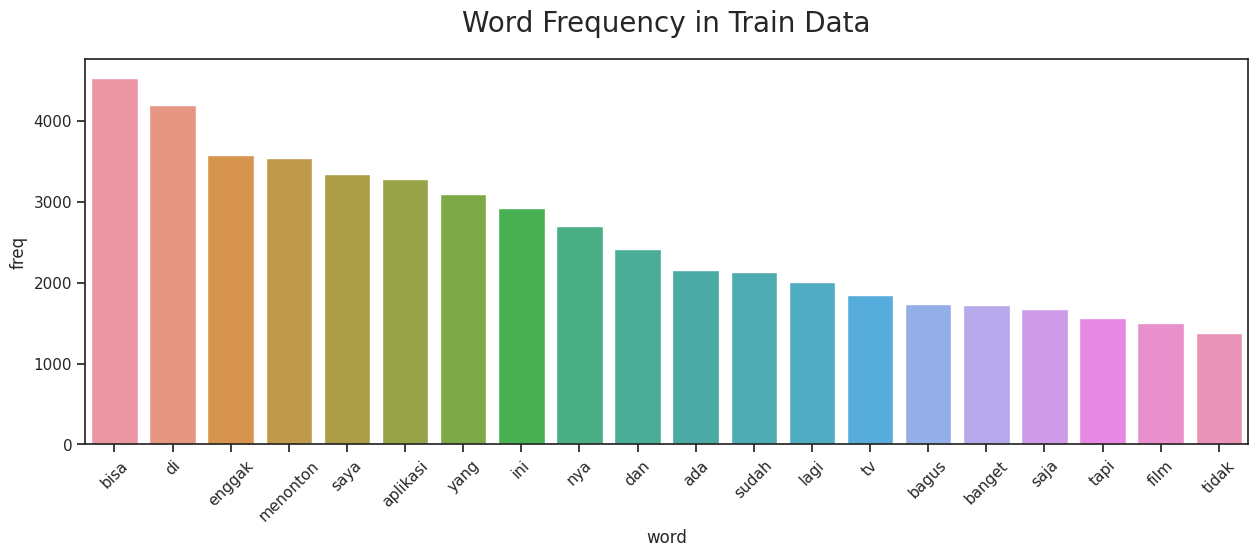

In [105]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

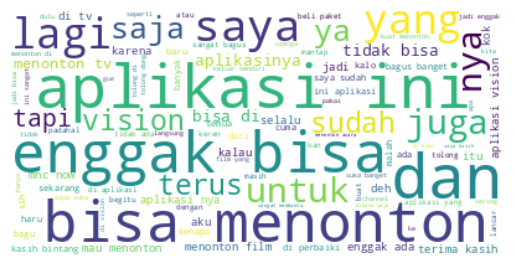

In [106]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [107]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [108]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (5599, 11)
Val shape: (1608, 11)
Test shape: (792, 11)


In [109]:
train_set.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
2714,aced06de-188f-41df-a255-6ab835ace7ab,elly latifa,https://play-lh.googleusercontent.com/a/AGNmyx...,Mantul sekale appnya banyak chanel pilihan yan...,5,0,NaN,2020-10-09 16:08:41,"Terima kasih reviewnya, kami akan terus tingka...",2020-10-09 16:09:10,positive
5061,ed24ef38-261e-44df-abc7-864ee9d57f17,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ya sudah download hanya tidak ada gambarnya se...,5,0,3.3.2009,2018-09-17 20:59:34,Mohon Maaf atas ketidaknyamanannya.Silakan men...,2018-09-17 21:51:38,positive
7226,3b86948e-aea8-4a60-99a3-aa48f9caa6f6,Wawan Sndi,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplikasi babi buat menonton tv saja susah bang...,1,0,NaN,2023-04-10 22:24:29,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2023-04-10 22:36:40,negative
760,3c0909ec-02df-46ff-9ef3-e9492fa0ea3a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,streaming terputus otomatis setelah menit engg...,2,0,3.3.21,2019-04-22 9:31:34,Mohon Maaf atas ketidaknyamanannya.Silakan cob...,2019-04-22 9:32:47,negative
5039,5a6c9027-64b2-4cec-bf24-93bbda5acdb3,Lucas lucy,https://play-lh.googleusercontent.com/a/AGNmyx...,Aplikasinya bagus tapi pas gue menonton kok ka...,3,0,4.4.2005,2020-08-01 19:05:48,Mohon Maaf atas ketidaknyamanannya. Silakan co...,2020-08-01 21:39:22,neutral


In [110]:
train_set_main = train_set[["content", "category"]]
val_set_main = val_set[["content", "category"]]
test_set_main = test_set[["content", "category"]]
train_set_main.head()

,content,category
2714,Mantul sekale appnya banyak chanel pilihan yan...,positive
5061,Ya sudah download hanya tidak ada gambarnya se...,positive
7226,Aplikasi babi buat menonton tv saja susah bang...,negative
760,streaming terputus otomatis setelah menit engg...,negative
5039,Aplikasinya bagus tapi pas gue menonton kok ka...,neutral


In [111]:
# export to tsv
train_set_main.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set_main.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set_main.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [112]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [113]:
# Set random seed
set_seed(27)

## b. Load Model

In [114]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [116]:
count_param(model)

124443651

## c. Prepare Dataset

In [117]:
train_dataset_path = 'train_set.tsv'
valid_dataset_path = 'val_set.tsv'
test_dataset_path = 'test_set.tsv'

In [118]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [119]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [120]:
text = 'Saya masih ngetes dulu nih berlangganan 1 bulan yg sport'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Saya masih ngetes dulu nih berlangganan 1 bulan yg sport | Label : negative (47.005%)


In [121]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : negative (48.371%)


In [122]:
text = 'Sudah beli paket premium tapi gak bisa dipake nonton, harus login terus.. habis login tetep aja gak bisa dipake, suruh beli paket lagi'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Sudah beli paket premium tapi gak bisa dipake nonton, harus login terus.. habis login tetep aja gak bisa dipake, suruh beli paket lagi | Label : negative (49.653%)


In [123]:
print(torch.cuda.is_available())

True


## e. Fine Tuning & Prediksi Evaluation

In [124]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [125]:
# Train
n_epochs = 7
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.5917 LR:0.00000300: 100%|██████████| 175/175 [01:10<00:00,  2.49it/s]


(Epoch 1) TRAIN LOSS:0.5917 ACC:0.77 F1:0.54 REC:0.56 PRE:0.58 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6316 ACC:0.72 F1:0.52 REC:0.63 PRE:0.47:   2%|▏         | 1/51 [00:01<01:15,  1.51s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 1) VALID LOSS:0.4828 ACC:0.81 F1:0.57 REC:0.60 PRE:0.54


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.4472 LR:0.00000300: 100%|██████████| 175/175 [01:09<00:00,  2.51it/s]


(Epoch 2) TRAIN LOSS:0.4472 ACC:0.84 F1:0.59 REC:0.62 PRE:0.63 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.5490 ACC:0.72 F1:0.52 REC:0.63 PRE:0.46:   2%|▏         | 1/51 [00:01<00:54,  1.09s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 2) VALID LOSS:0.4561 ACC:0.83 F1:0.59 REC:0.61 PRE:0.77


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.4052 LR:0.00000300: 100%|██████████| 175/175 [01:10<00:00,  2.49it/s]


(Epoch 3) TRAIN LOSS:0.4052 ACC:0.85 F1:0.62 REC:0.63 PRE:0.70 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4517 ACC:0.83 F1:0.61 REC:0.62 PRE:0.68: 100%|██████████| 51/51 [00:09<00:00,  5.62it/s]


(Epoch 3) VALID LOSS:0.4517 ACC:0.83 F1:0.61 REC:0.62 PRE:0.68


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.3741 LR:0.00000300: 100%|██████████| 175/175 [01:09<00:00,  2.51it/s]


(Epoch 4) TRAIN LOSS:0.3741 ACC:0.86 F1:0.65 REC:0.66 PRE:0.72 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4611 ACC:0.83 F1:0.63 REC:0.64 PRE:0.68: 100%|██████████| 51/51 [00:09<00:00,  5.64it/s]


(Epoch 4) VALID LOSS:0.4611 ACC:0.83 F1:0.63 REC:0.64 PRE:0.68


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.3402 LR:0.00000300: 100%|██████████| 175/175 [01:09<00:00,  2.53it/s]


(Epoch 5) TRAIN LOSS:0.3402 ACC:0.87 F1:0.70 REC:0.69 PRE:0.76 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4718 ACC:0.82 F1:0.66 REC:0.66 PRE:0.67: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


(Epoch 5) VALID LOSS:0.4718 ACC:0.82 F1:0.66 REC:0.66 PRE:0.67


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 6) TRAIN LOSS:0.3044 LR:0.00000300: 100%|██████████| 175/175 [01:08<00:00,  2.56it/s]


(Epoch 6) TRAIN LOSS:0.3044 ACC:0.88 F1:0.73 REC:0.72 PRE:0.78 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.5071 ACC:0.81 F1:0.64 REC:0.64 PRE:0.65: 100%|██████████| 51/51 [00:09<00:00,  5.36it/s]


(Epoch 6) VALID LOSS:0.5071 ACC:0.81 F1:0.64 REC:0.64 PRE:0.65


  0%|          | 0/175 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 7) TRAIN LOSS:0.2651 LR:0.00000300: 100%|██████████| 175/175 [01:08<00:00,  2.55it/s]


(Epoch 7) TRAIN LOSS:0.2651 ACC:0.90 F1:0.78 REC:0.76 PRE:0.81 LR:0.00000300


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.5262 ACC:0.81 F1:0.65 REC:0.66 PRE:0.66: 100%|██████████| 51/51 [00:09<00:00,  5.47it/s]

(Epoch 7) VALID LOSS:0.5262 ACC:0.81 F1:0.65 REC:0.66 PRE:0.66


### Learning Curve

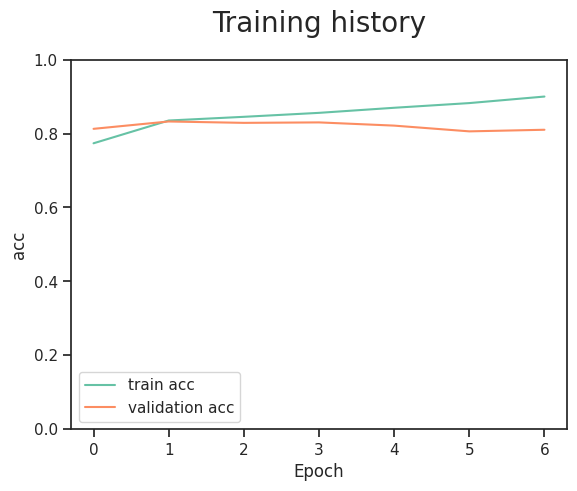

In [126]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [127]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [128]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 25/25 [00:05<00:00,  4.97it/s]


In [129]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [130]:
text = 'Tolong tingkatkan lagi. Lagi enak2 nonton sampai pertengahan suka mbalik lagi ke awal. Ksel bgt gtu2 terus jadi ga nyaman bgt. Pdhl pngen nostalgia senitron2 lama tapi aplikasi nya krg memuaskan bgt ...!!!!!!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Tolong tingkatkan lagi. Lagi enak2 nonton sampai pertengahan suka mbalik lagi ke awal. Ksel bgt gtu2 terus jadi ga nyaman bgt. Pdhl pngen nostalgia senitron2 lama tapi aplikasi nya krg memuaskan bgt ...!!!!!!! | Label : negative (51.072%)


In [131]:
text = 'Suka banget sm vision smoga lancar lancar terus'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Suka banget sm vision smoga lancar lancar terus | Label : positive (99.686%)


In [132]:
text = 'permisi masalah kendala kemarin sudah selesai sekarang ada kendala lagi kenapa sekarang tidak ada load more nya ya sekarang kalo mau scroll episode kebawah lama banget dan juga agak eror karena setiap saya scroll kebawah untuk episode berikut nya selalu kembali ke halaman pencarian tolong ya diperbaiki dan saran saya kalo bisa di buat auto play untuk episode selanjutnya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: permisi masalah kendala kemarin sudah selesai sekarang ada kendala lagi kenapa sekarang tidak ada load more nya ya sekarang kalo mau scroll episode kebawah lama banget dan juga agak eror karena setiap saya scroll kebawah untuk episode berikut nya selalu kembali ke halaman pencarian tolong ya diperbaiki dan saran saya kalo bisa di buat auto play untuk episode selanjutnya | Label : neutral (58.574%)


# 6. Evaluasi

In [133]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

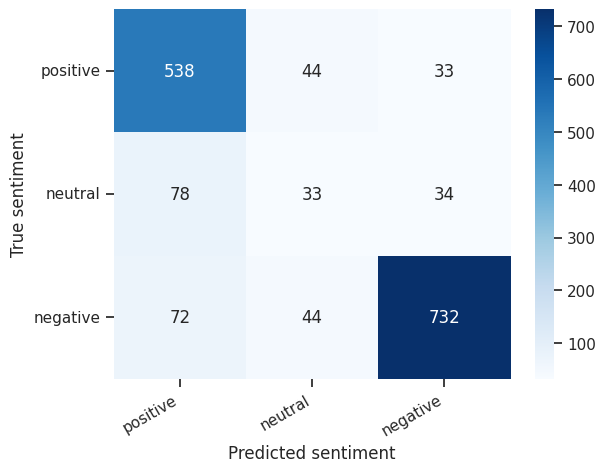

In [134]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [135]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.78      0.87      0.83       615
     neutral       0.27      0.23      0.25       145
    negative       0.92      0.86      0.89       848

    accuracy                           0.81      1608
   macro avg       0.66      0.66      0.65      1608
weighted avg       0.81      0.81      0.81      1608



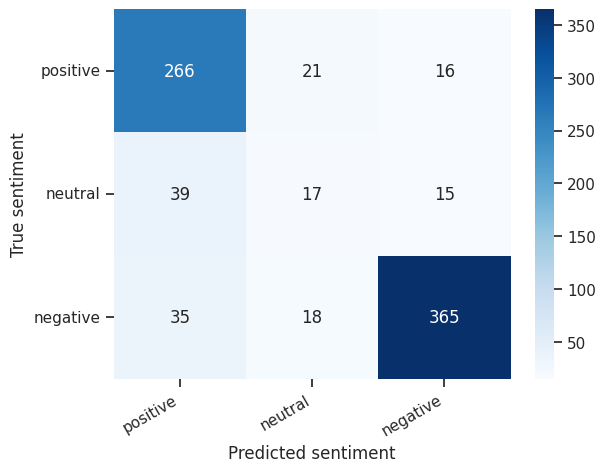

In [136]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [137]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.78      0.88      0.83       303
     neutral       0.30      0.24      0.27        71
    negative       0.92      0.87      0.90       418

    accuracy                           0.82       792
   macro avg       0.67      0.66      0.66       792
weighted avg       0.81      0.82      0.81       792

